### Imports

In [53]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import mne



from entropy import *
from scipy import signal

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from lib import utils

### Load EEG Data

In [54]:
# load from csv

filename = 'Muse-357D_2019-12-17--14-20-44_1576623304487.csv'

RECORDS = pd.read_csv("data/" +  filename,low_memory=False)

# reset time to zero
RECORDS['timestamps'] = RECORDS['timestamps'] - RECORDS['timestamps'].iloc[0]

## Filter Records 

In [55]:
def filter_records(start_t=0.0,stop_t=None):
    data = RECORDS[RECORDS['timestamps'] > start_t]
    if stop_t != None: data = data[data['timestamps']<stop_t]
    return data

In [56]:
DATA = filter_records(150, 325)

## Plot EEG Channels

In [57]:
def plot_muse(channel,show=True):
    data = DATA[DATA[channel].notnull()][['timestamps',channel]]
    plt.plot(data['timestamps'],data[channel],label=channel)
    
    if(show): plt.title(channel) ; plt.show()

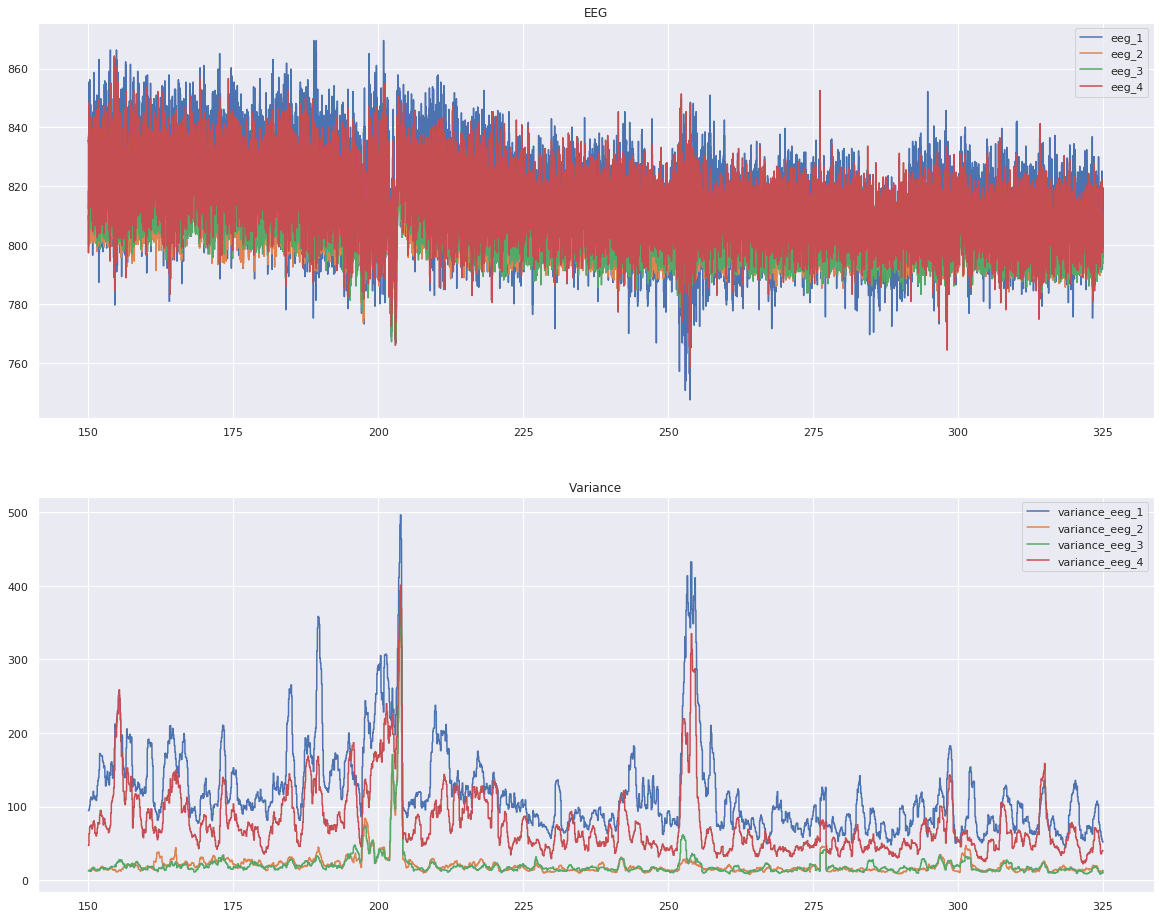

In [58]:
sns.set(rc={'figure.figsize':(20, 16)})
for i in range (1,5):
    plt.subplot(211)
    plot_muse('eeg_'+str(i),False)
    plt.legend()
    plt.title('EEG')
    
    plt.subplot(212)
    plot_muse('variance_eeg_'+str(i),False)
    plt.legend()
    plt.title('Variance')

plt.show()

## PPG

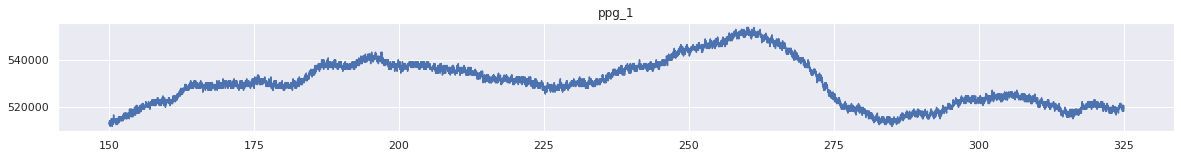

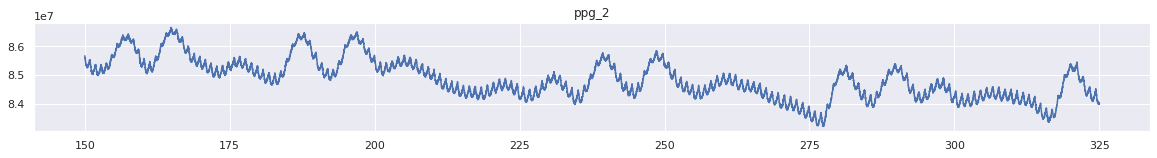

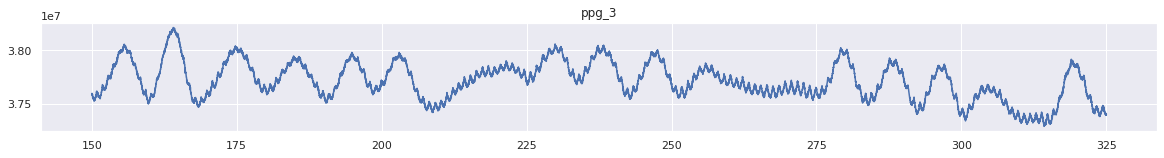

In [59]:
sns.set(rc={'figure.figsize':(20, 2)})
plot_muse('ppg_1')
plot_muse('ppg_2')
plot_muse('ppg_3')

## Acceleration & Gryo

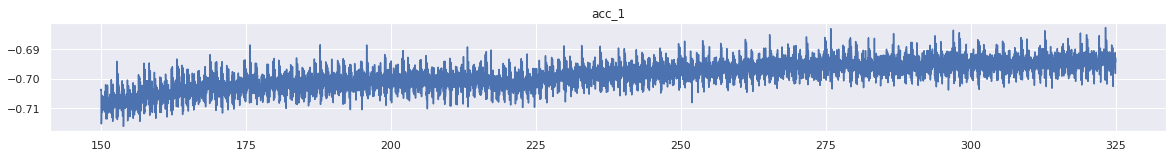

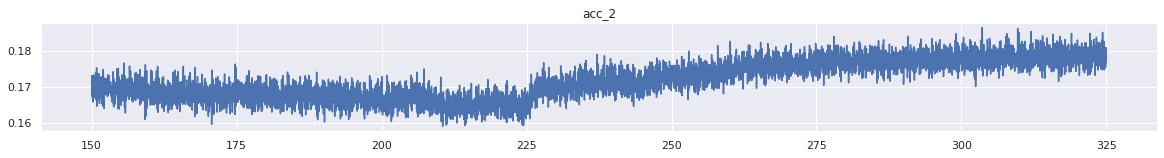

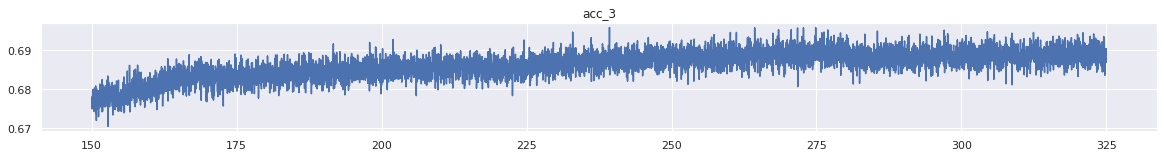

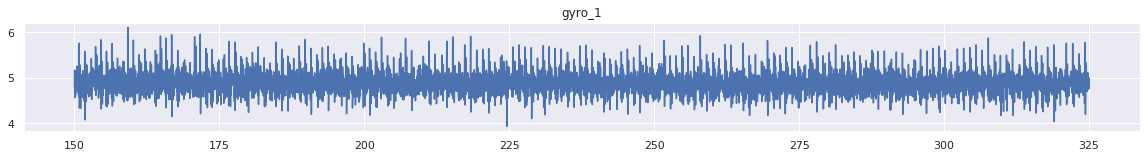

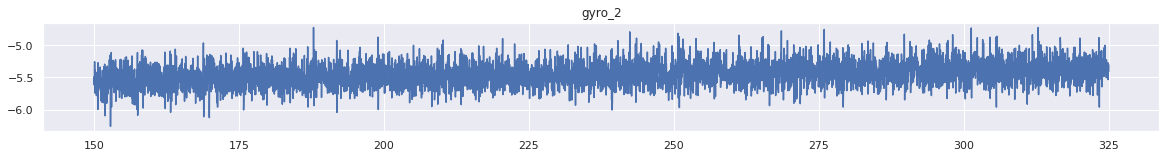

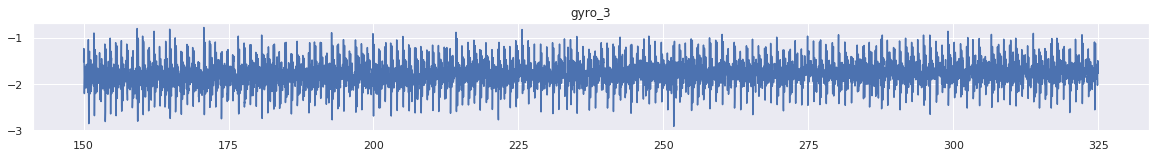

In [60]:
sns.set(rc={'figure.figsize':(20, 2)})
plot_muse('acc_1')
plot_muse('acc_2')
plot_muse('acc_3')

plot_muse('gyro_1')
plot_muse('gyro_2')
plot_muse('gyro_3')

## Blink & Jaw Clench 

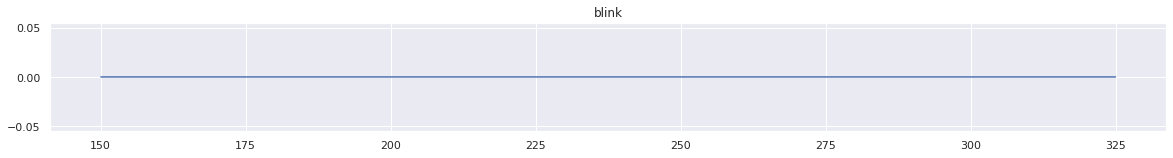

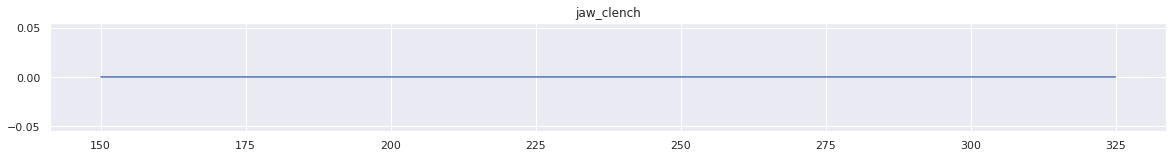

In [61]:
plot_muse('blink')
plot_muse('jaw_clench')

## Battery

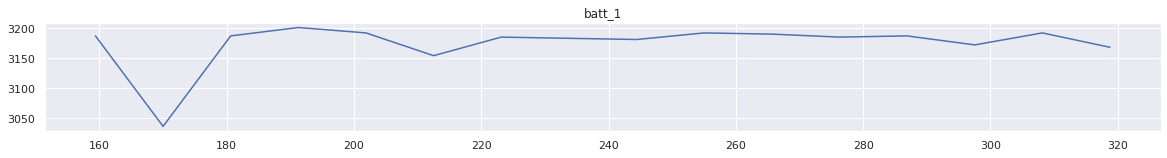

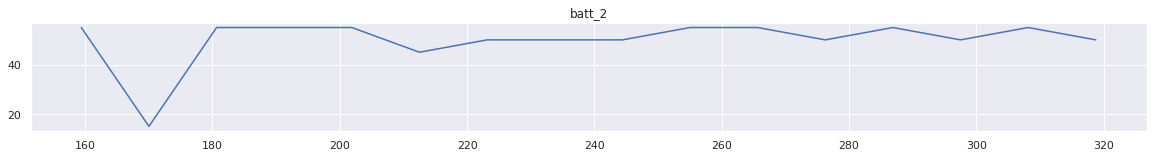

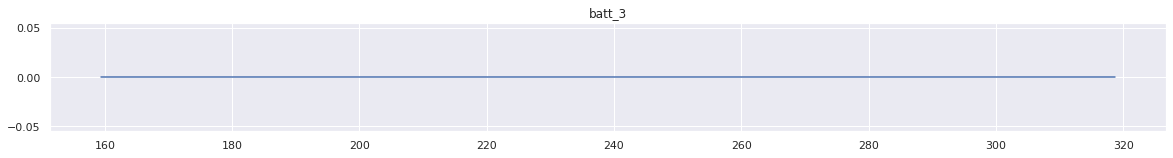

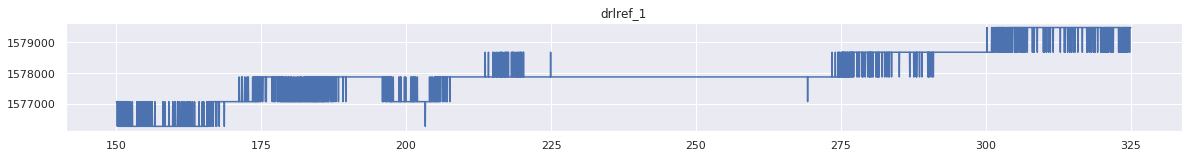

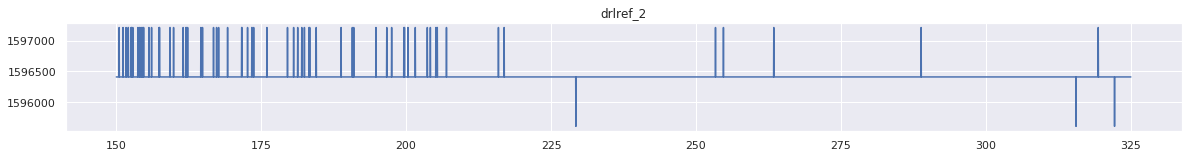

In [62]:
plot_muse('batt_1')
plot_muse('batt_2')
plot_muse('batt_3')
plot_muse('drlref_1')
plot_muse('drlref_2')

## Dictionary

In [63]:
WAVES = ['delta','theta', 'alpha', 'beta', 'gamma']
MEASURES = ['absolute', 'relative']
CHANNELS = ['1','4','2','3']
REGIONS = {'1':"TP9", '2':'AF7', '3':'AF8','4':'TP10'}
COLORS = {'ilf':'#000000','delta':'#FF0000', 'theta':'#FF7F00', 'alpha':'#00FF00','beta':'#0000FF','beta (f)':'#000099','gamma':'#4B0082', 'gamma (f)':'#EE82EE','epsilon':'#4B0082','epsilon (f)':'#290060'}
RANGES = {'ilf':[0,1.5],'delta':[1.5,4],'theta':[4,8],"alpha":[8,12],'beta':[13,22], 'beta (f)':[22,32],'gamma':[34,59], 'gamma (f)':[67,99],'epsilon':[101,119]}

## Get Brain Waves

In [64]:
BRAINWAVES = {}
for frequency in WAVES:
    for measure in MEASURES:
        wave = frequency + '_' + measure
        waves = DATA[["timestamps",wave + '_1', wave +'_2', wave + '_3', wave + '_4']].dropna()
        waves[frequency + '_' + measure + '_average'] = waves.loc[:, waves.columns != 'timestamps'].mean(axis=1)
    
        BRAINWAVES[wave] = waves

## Plot Channels

In [65]:
def plot_channels(measure='absolute'):
    for channel in CHANNELS:
        plot_channel(channel,measure)

def plot_channel(channel,measure='absolute'):
    sns.set(rc={'figure.figsize':(20, 16)})
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(2, 1)

    ax = plt.subplot(2, 1, 1)
    waves = [] ; colors = []
    for wave in WAVES: 
        waves.append(np.abs(BRAINWAVES.get(wave + '_' + measure)[wave + '_' + measure + '_' + channel]))
        colors.append(COLORS[wave])
    ts = BRAINWAVES.get('delta' + '_' + measure)['timestamps']
    ax.stackplot(ts, waves,labels=(WAVES),colors=colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    if (channel != 'average'): plt.title(REGIONS[channel] + ' - ' + measure)

    sns.set_style("whitegrid")
    plt.subplot(2, 1, 2)
    for wave in WAVES:
        data = BRAINWAVES.get(wave + '_' + measure)
        ts = data['timestamps']
        plt.plot(ts,data[wave + '_' + measure + '_' + channel],COLORS[wave],label=wave)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    if (channel != 'average'): plt.title(REGIONS[channel] + ' - ' + measure)
    

## All Channels - Average Value

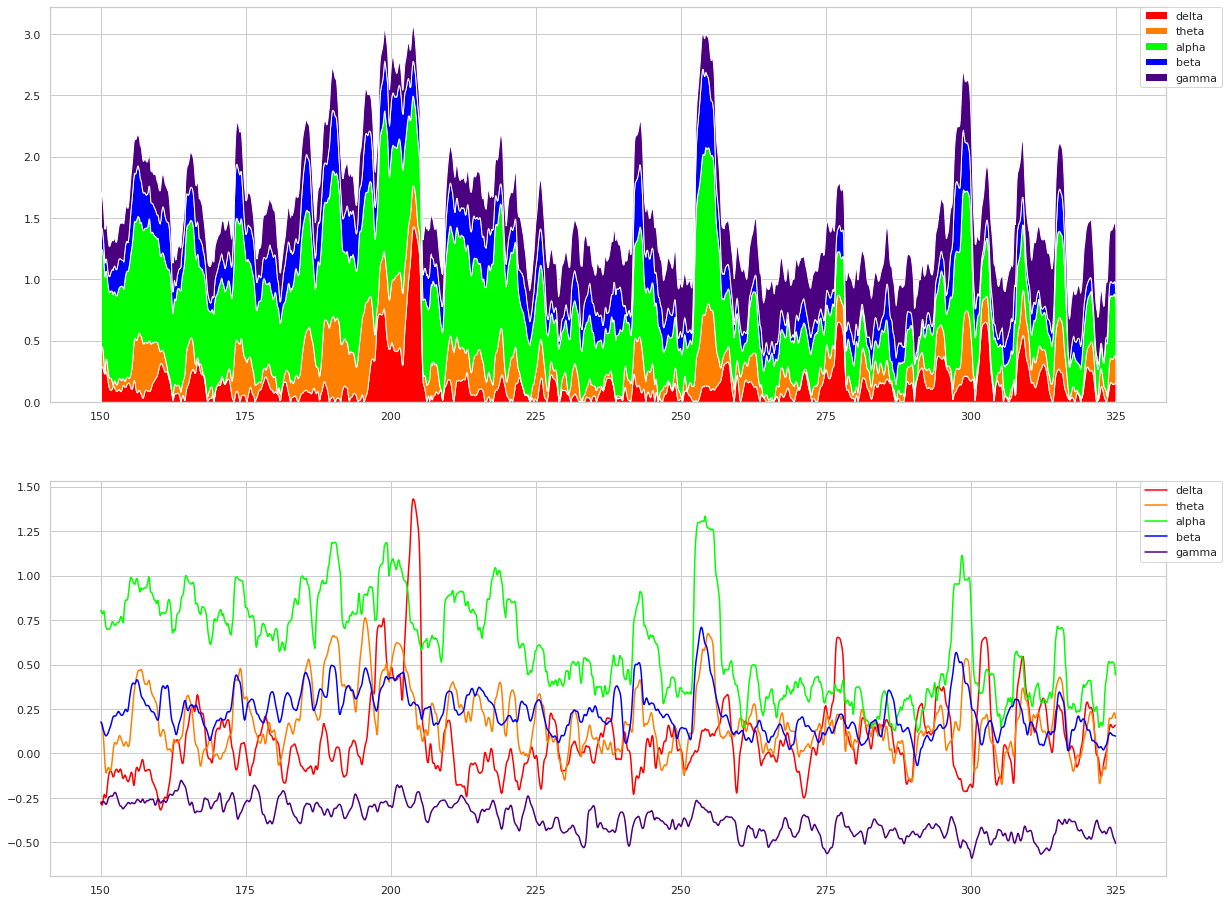

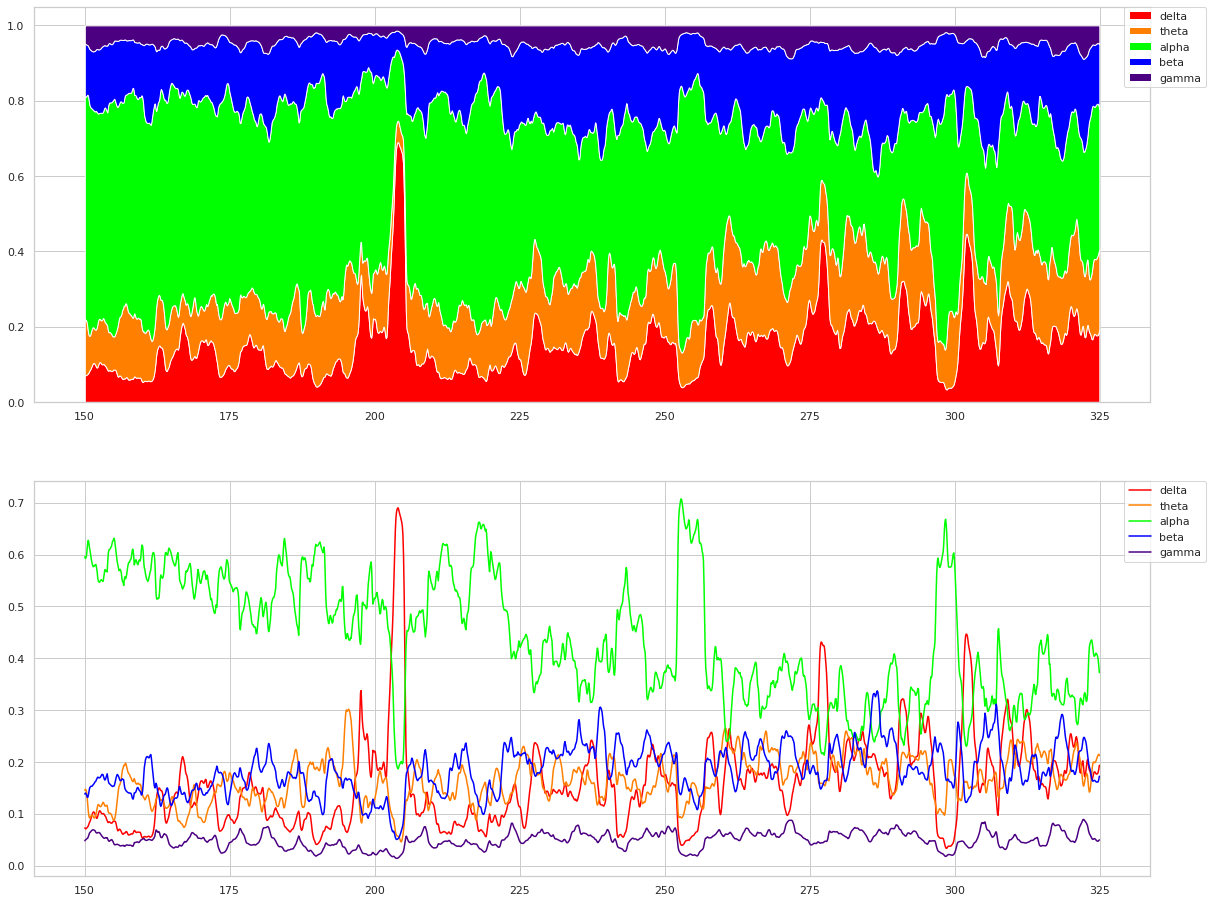

In [66]:
plot_channel('average')
plot_channel('average','relative')

## Channels &  Frequency Bands - Absolute Value 

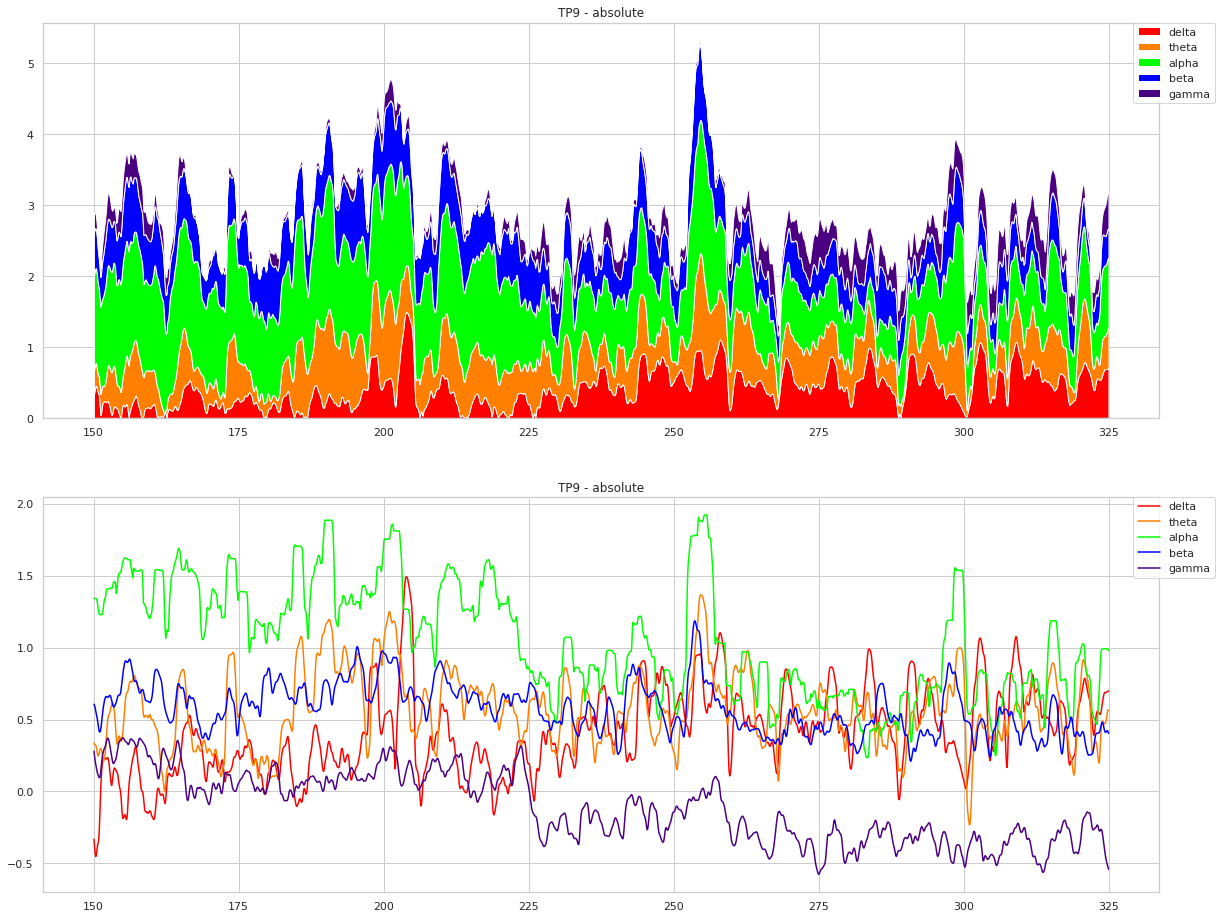

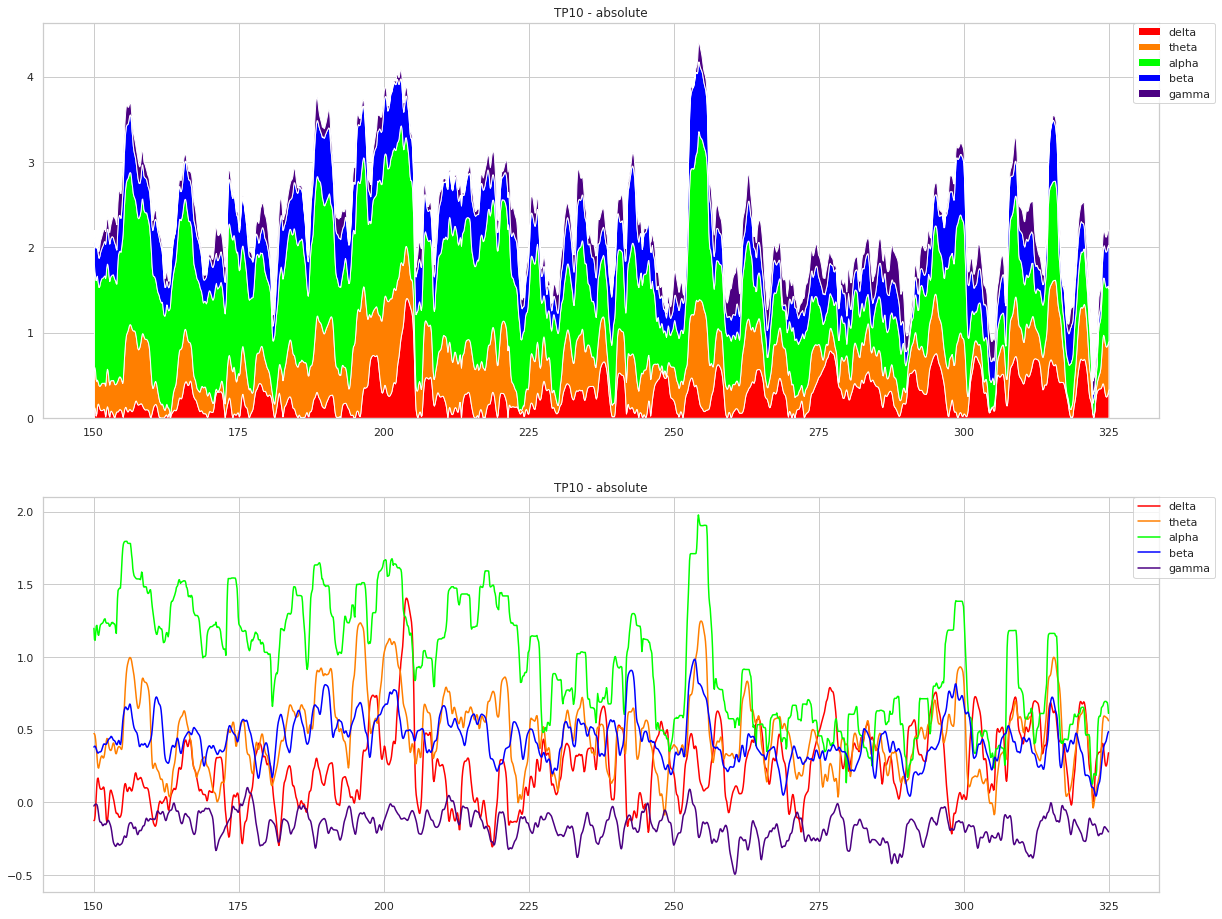

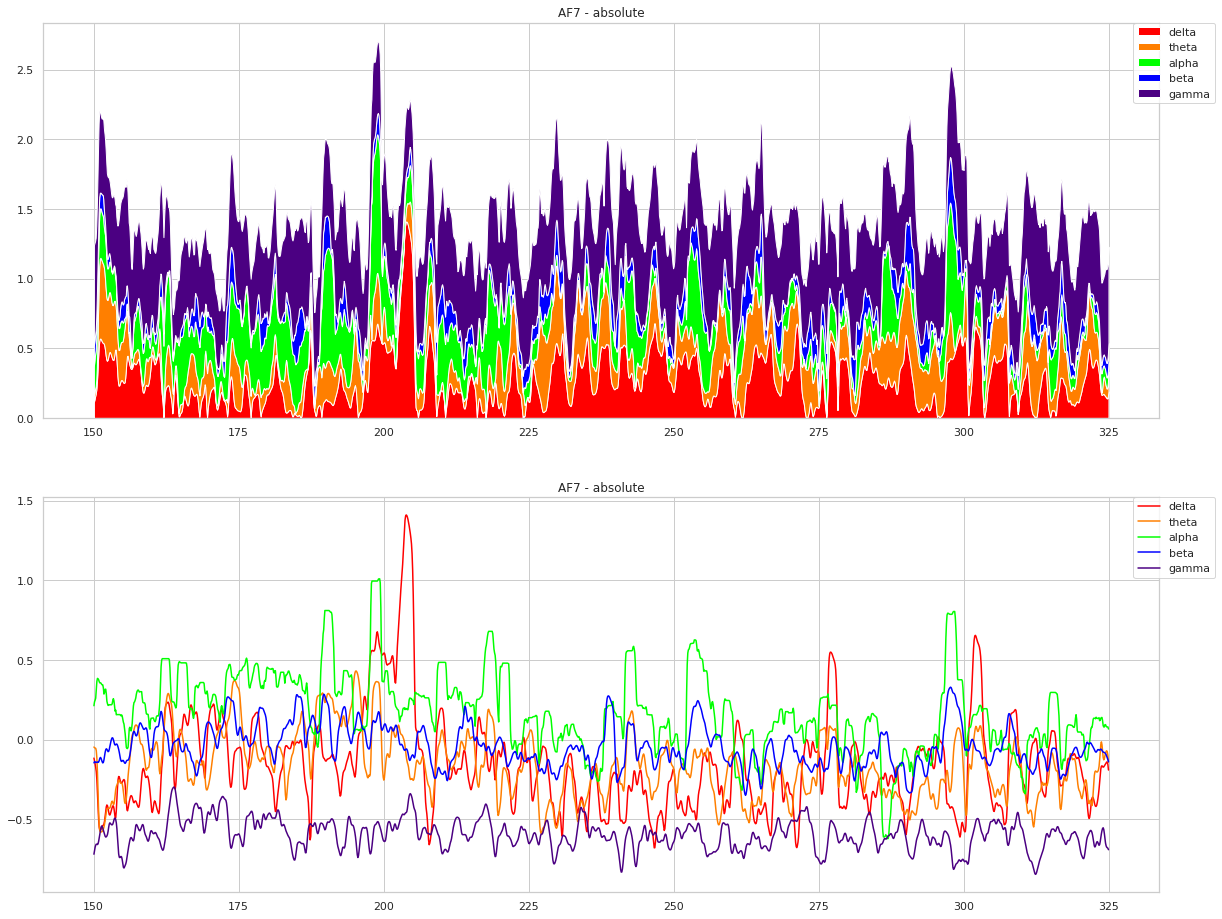

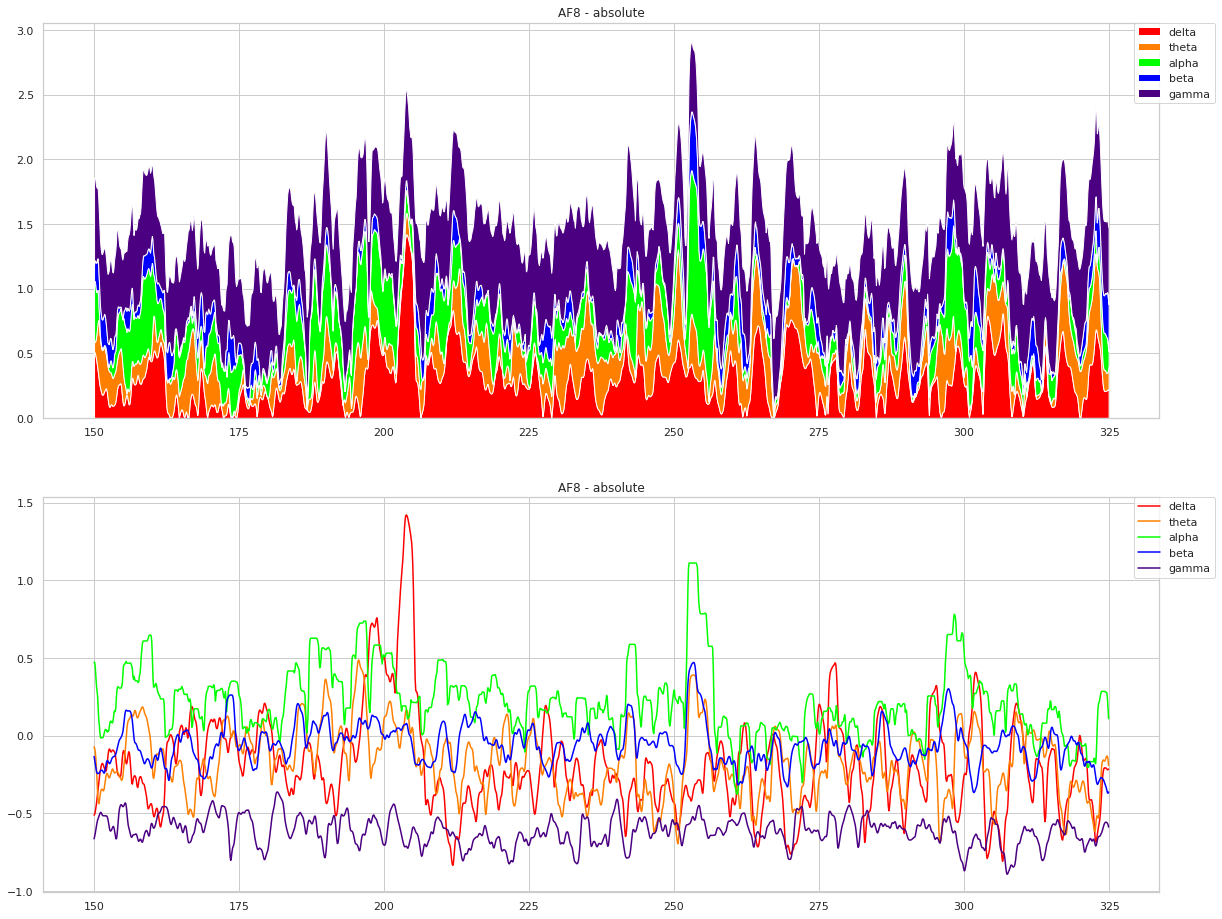

In [67]:
plot_channels()

## Channels &  Frequency Bands - Relative Value 

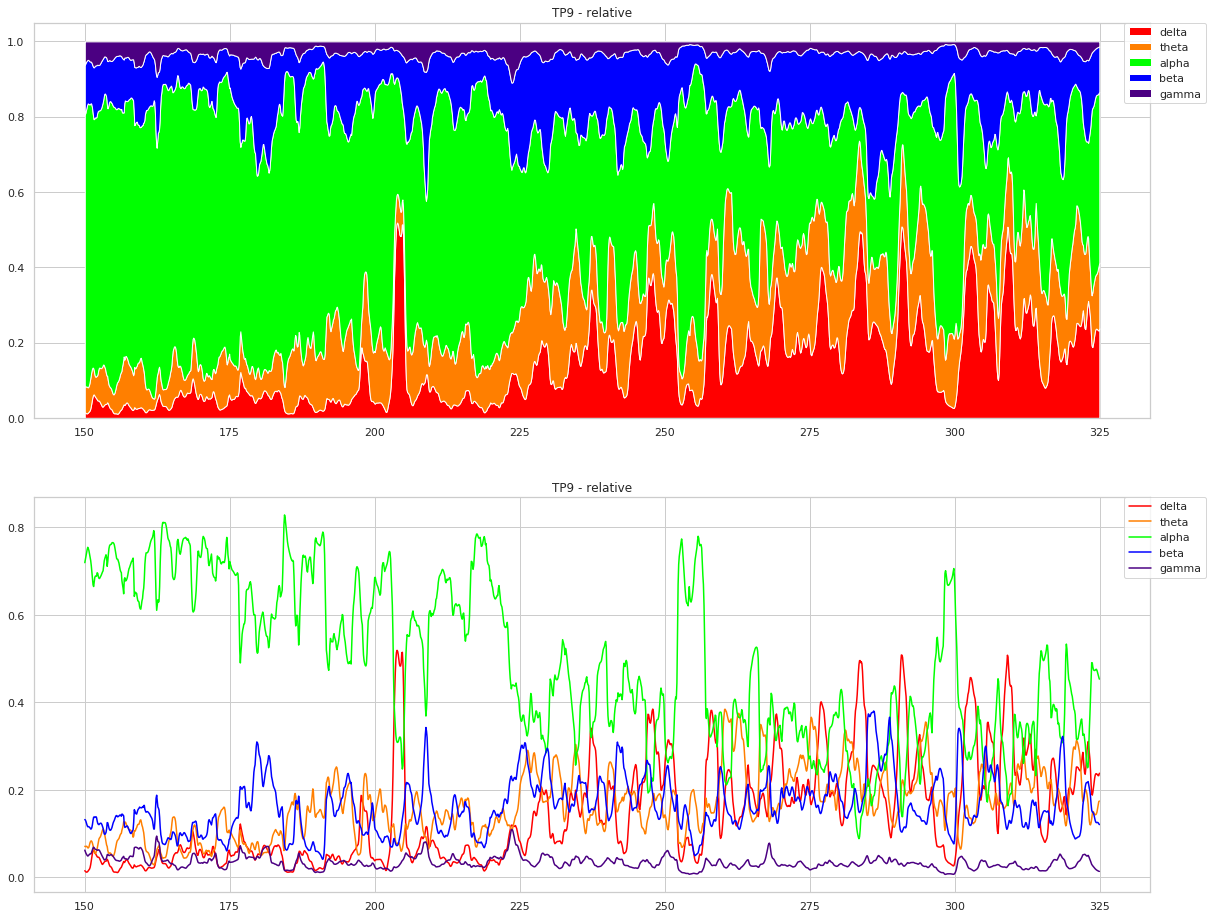

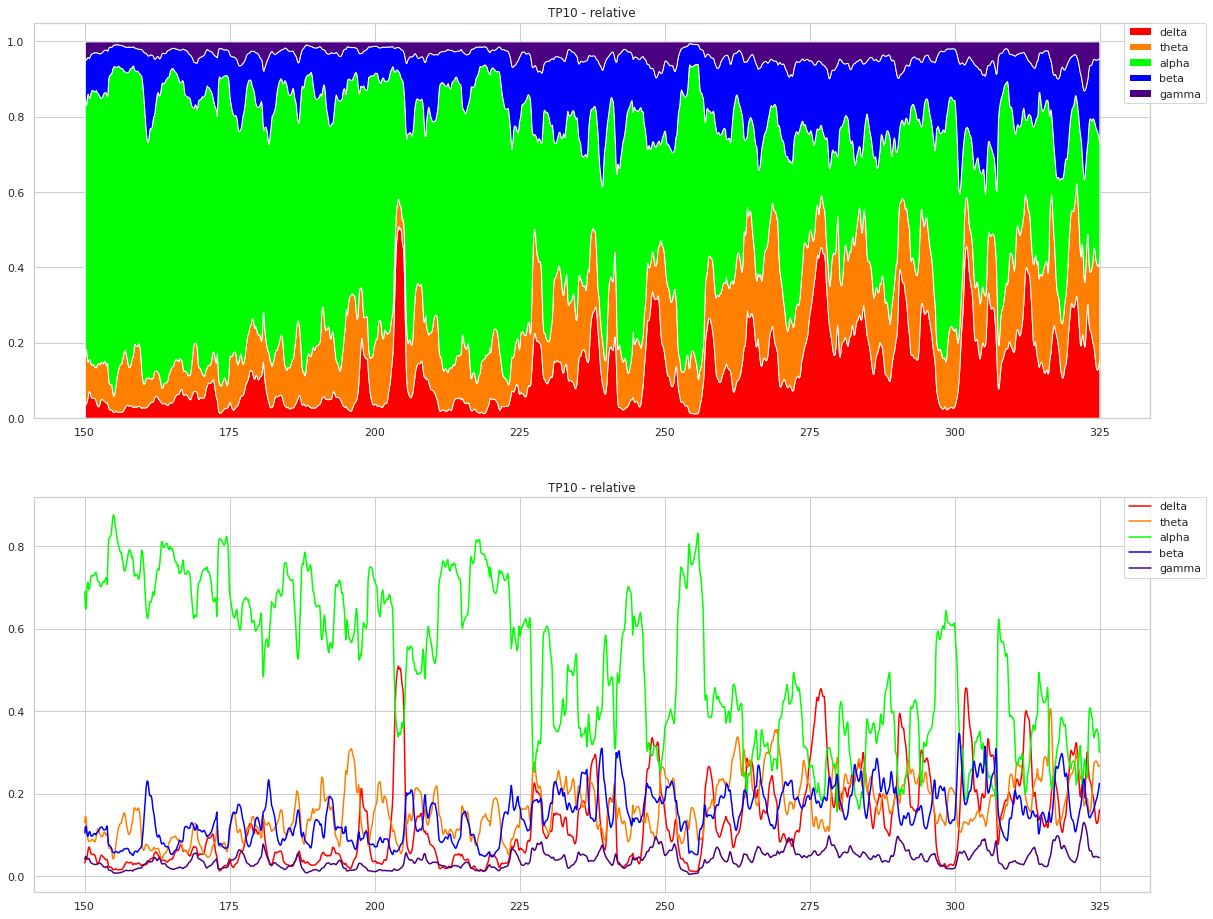

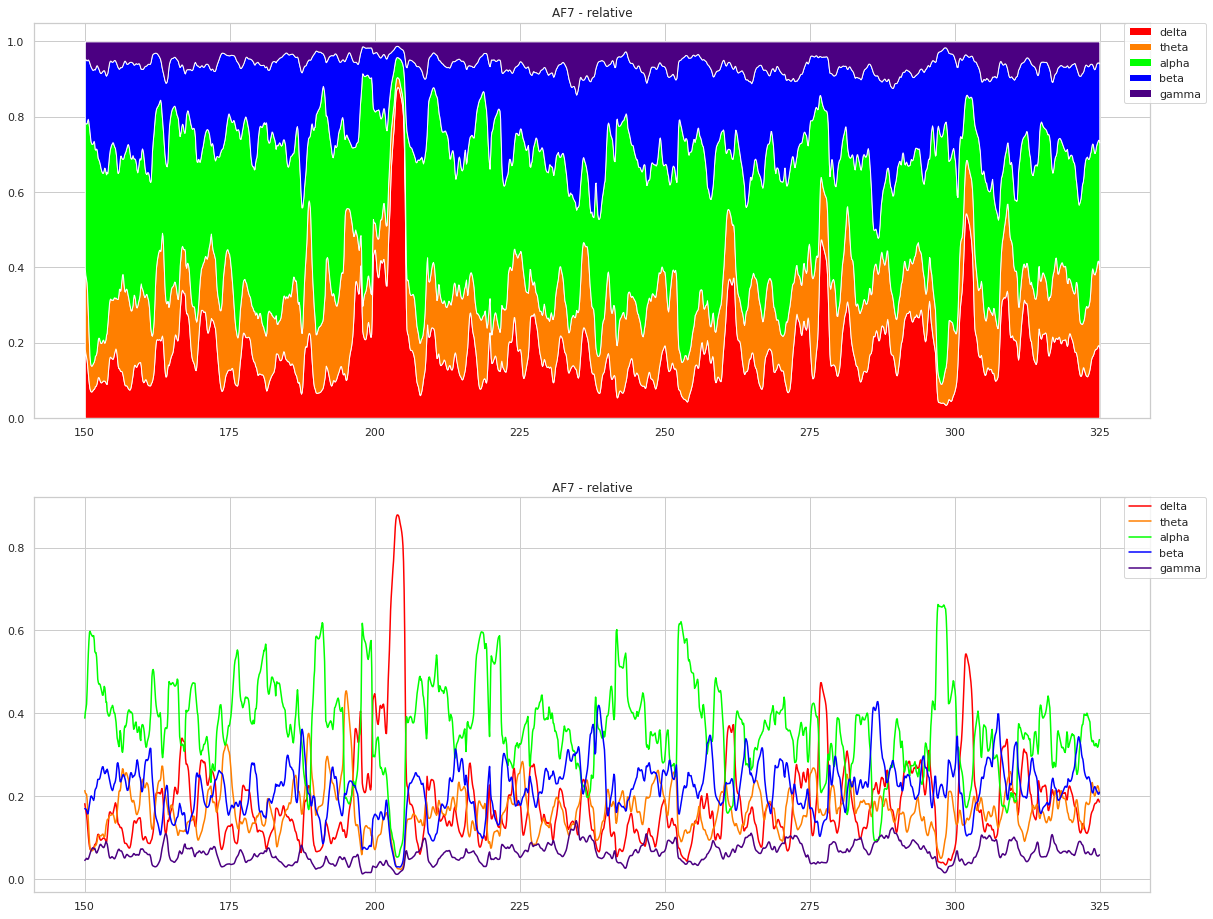

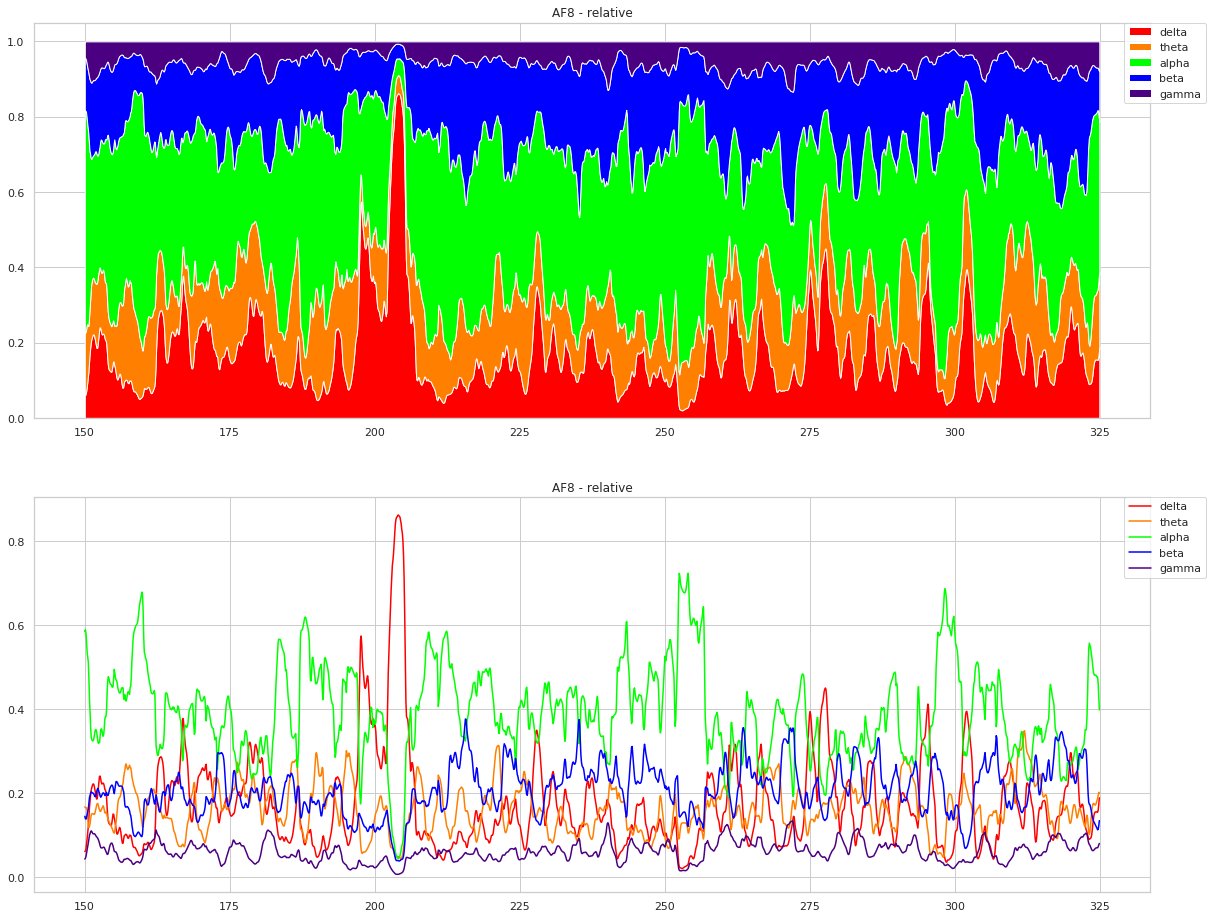

In [68]:
plot_channels('relative')

## Bandpower Summary 

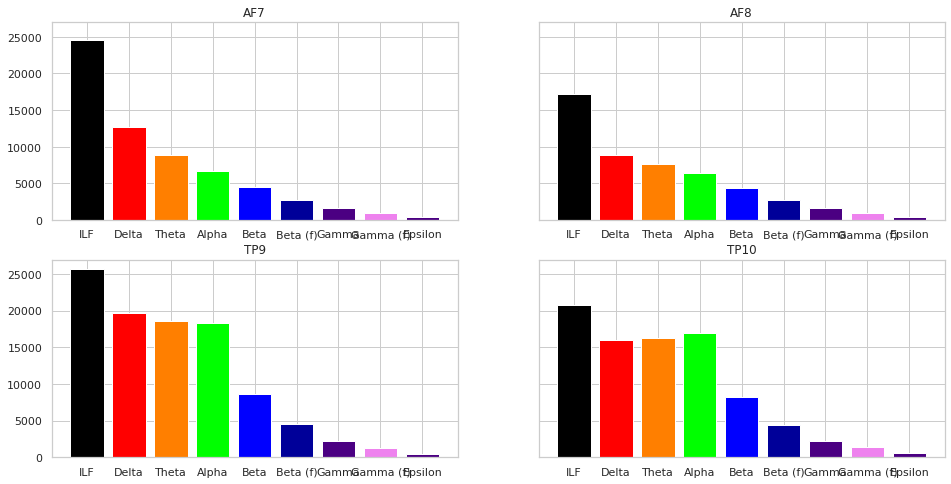

In [69]:
fs = 256  # Sampling rate (512 Hz)

fig, axes = plt.subplots(2, 2,figsize=(16,8),sharey=True)
axes = axes.flatten()

for i, channel in enumerate(['2','3','1','4']):
    # filter records
    data = RECORDS['eeg_'+channel].dropna()
    
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'ILF' : (0.5,1.5),
                 'Delta': (1.5, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (13, 22),
                 'Beta (f)': (22, 32),
                 'Gamma': (34, 59),
                 'Gamma (f)': (67, 99),
                 'Epsilon': (101,119)}
    
    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    total = np.sum(list(eeg_band_fft.values()))
#     vals = [100*eeg_band_fft[band]/total for band in eeg_bands]
    vals = [eeg_band_fft[band] for band in eeg_bands]

    # Plot the data (using pandas here cause it's easy)
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = vals
    axes[i].bar(df['band'], df['val'],color=COLORS.values())
    axes[i].set_title(REGIONS[channel])
#     ax.set_xlabel("EEG Band")
#     ax.set_ylabel("Relative Power (%)")
#     ax.set_title(REGIONS['1'])

## Power Spectral Density 

In [70]:
SF = 256         # sampling frequency
WIN = 10 * SF     # window length (4 sec)

def spectral_density(freq):
    fig, axes = plt.subplots(2, 2,figsize=(15,8))
    axes = axes.flatten()

    for i, channel in enumerate(['2','3','1','4']):
        # filter records
        data = RECORDS['eeg_'+channel].dropna()

        # welch signal
        freqs, psd = signal.welch(data, SF, nperseg=WIN)

        # Find intersecting values in frequency vector
        low = RANGES[freq][0] ; high = RANGES[freq][1] ; 
        idx_delta = np.logical_and(freqs >= low, freqs <= high)

        # Plot the power spectral density and fill the delta area
        axes[i].plot(freqs, psd, lw=2, color='k')
        axes[i].fill_between(freqs, psd, where=idx_delta, color=COLORS[freq])
        #axes[i].set(xlabel='Frequency (Hz)')
        axes[i].set(xlim=[low-.1, high+.1])
        axes[i].set(xticks=np.arange(low, high, step=1))

        ymax = max(psd[np.all([freqs >= low, freqs <= high], axis=0)])
        axes[i].set(ylim=[0, 1.1*ymax])
        axes[i].set(title=freq + ' - ' + REGIONS[channel])
        sns.despine()

def spectral_density_summary():
    for freq in list(RANGES.keys()):
        spectral_density(freq)

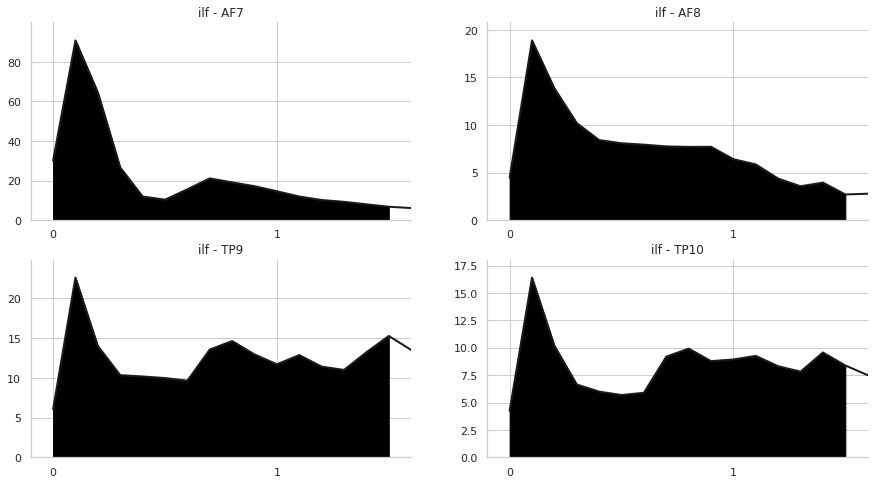

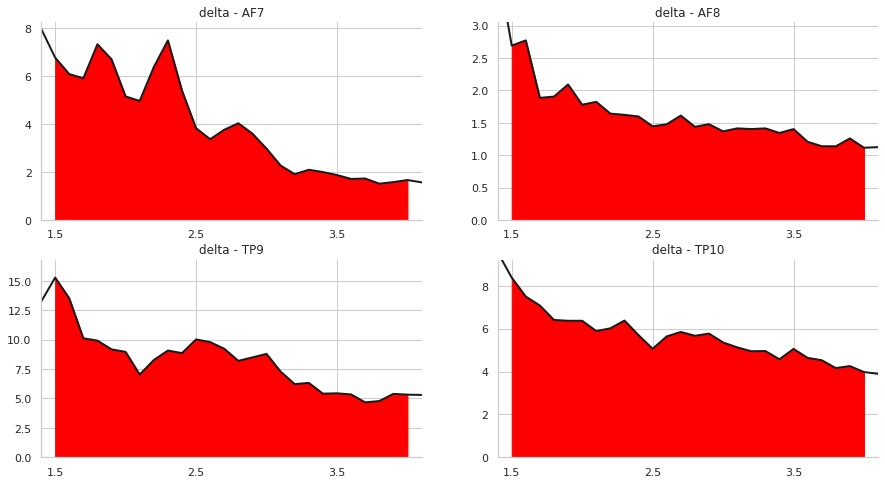

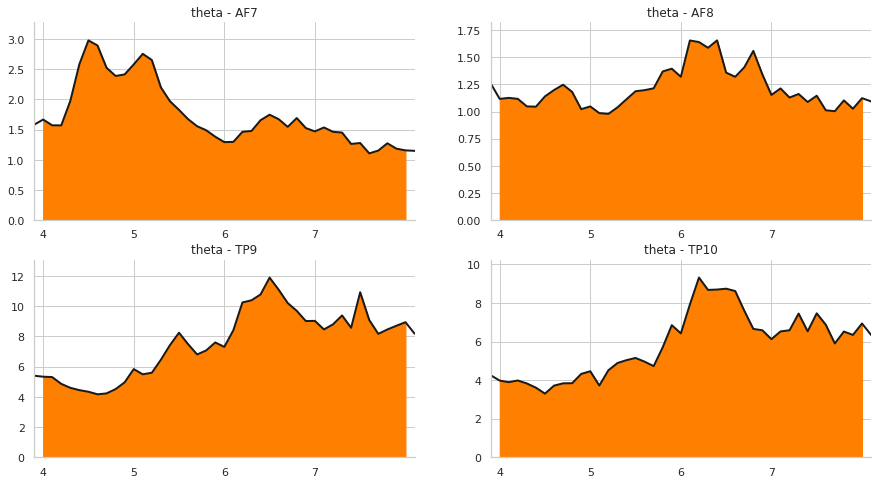

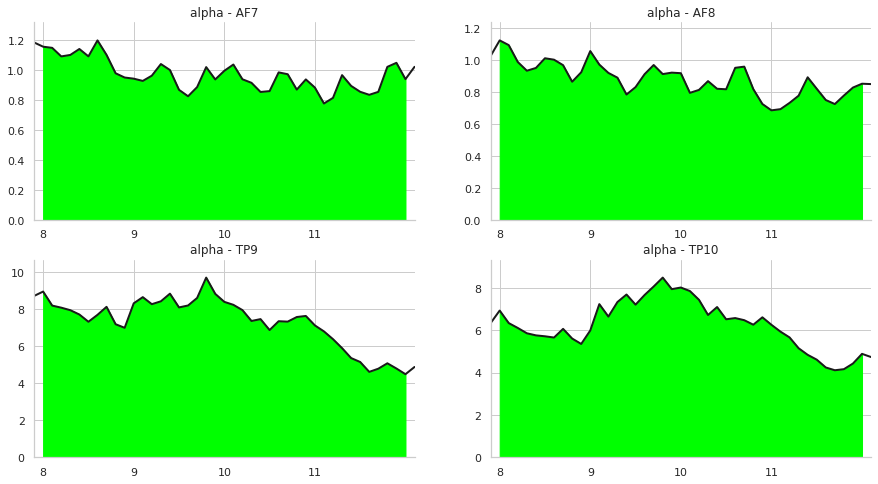

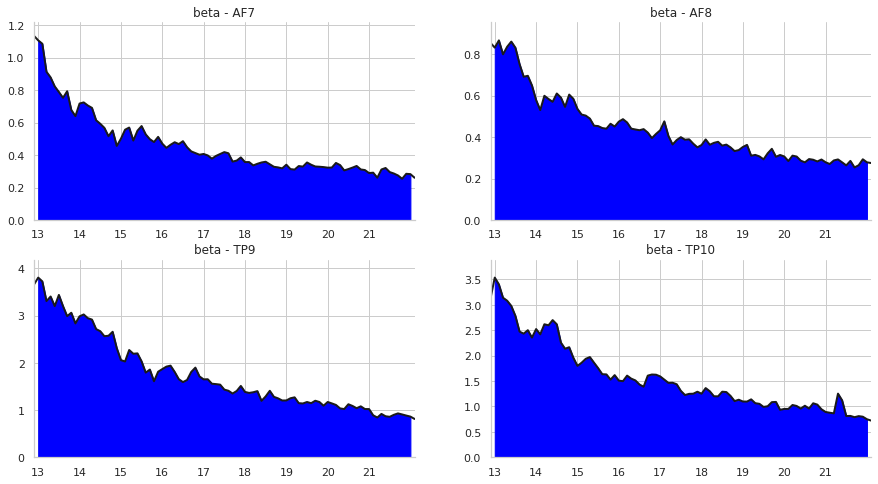

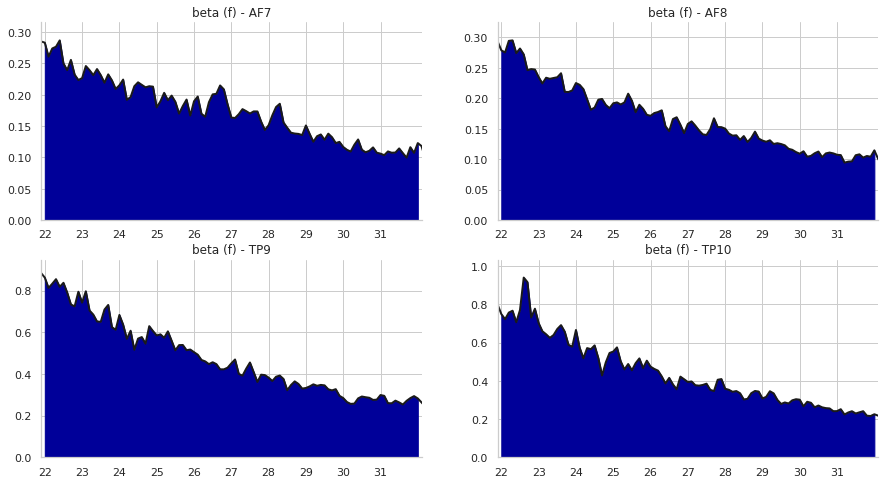

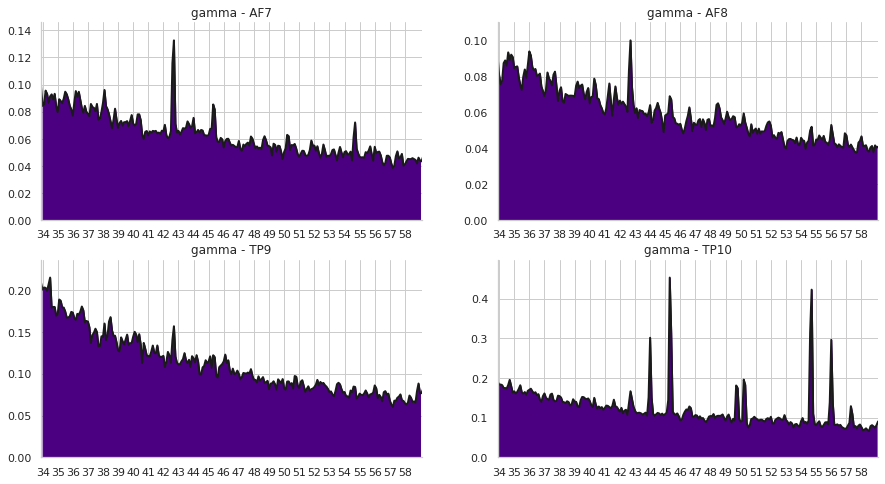

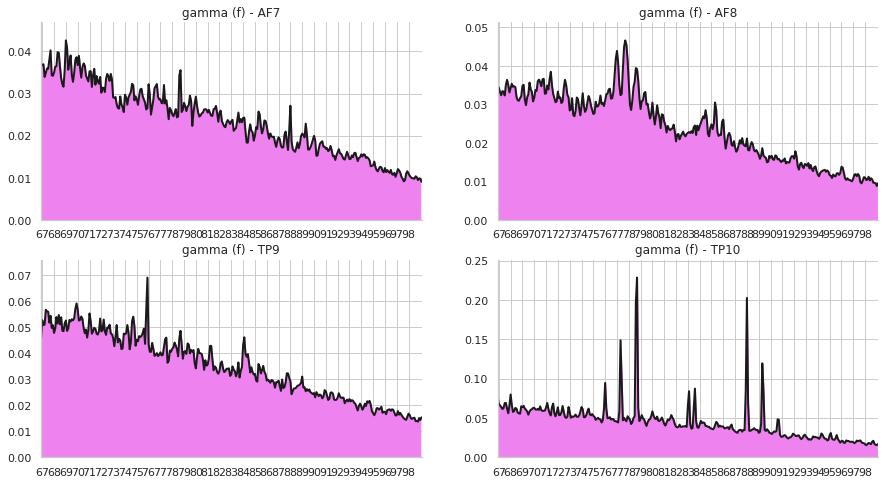

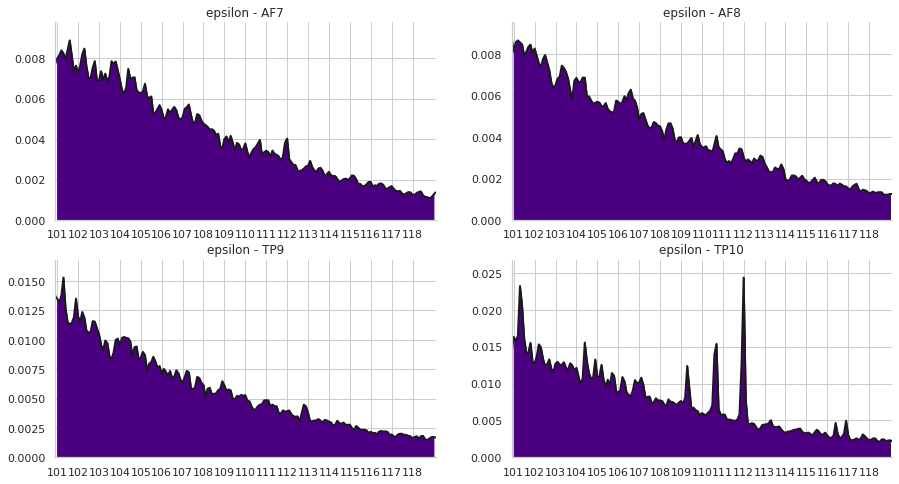

In [71]:
spectral_density_summary()

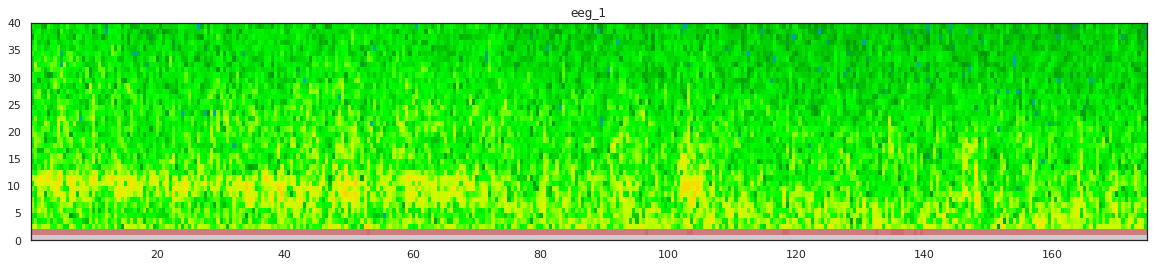

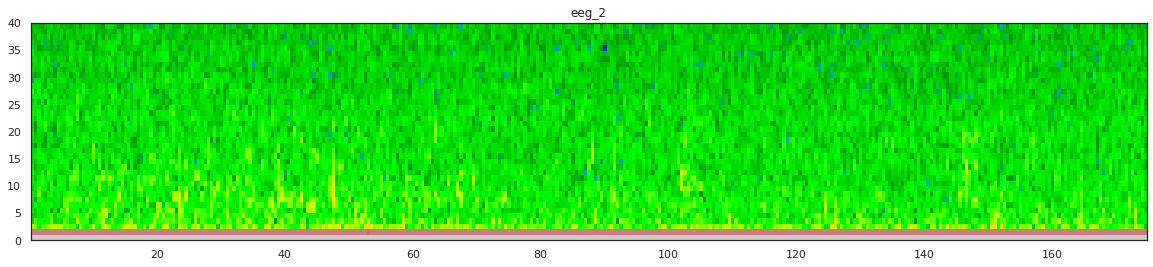

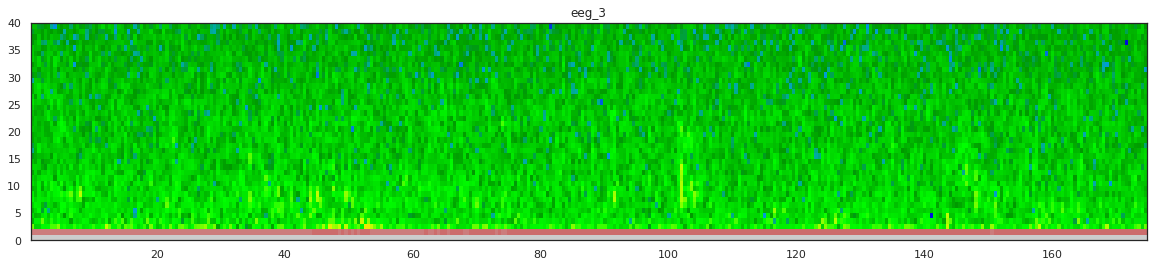

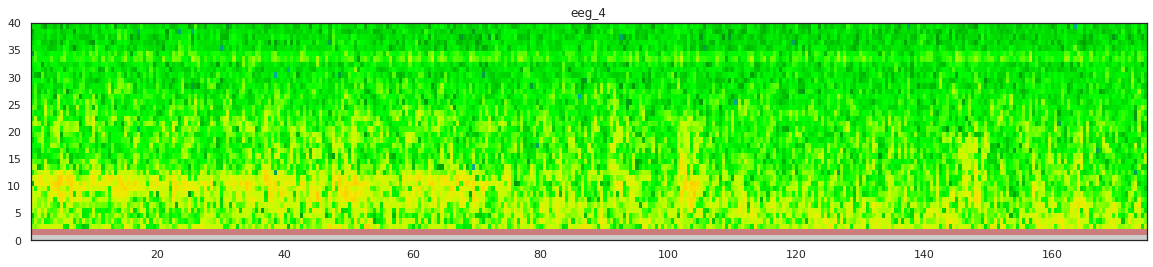

In [72]:
for i in range(1,5):
    channel = 'eeg_' + str(i)
    data =  DATA[DATA[channel].notnull()][channel]
    cmap = plt.cm.get_cmap("nipy_spectral")
    sns.set(rc={'figure.figsize':(20, 4)})
    sns.set_style("white")
    plt.specgram(data,Fs=256,cmap=cmap)
    plt.axis(ymin=0, ymax=40)
    plt.title(channel)
    plt.show()

## Higuchi Fractal Dimension

In [73]:
def fractal_summary():
    print('\t LB \t LF \t RF \t RB')
    
    print('eeg\t%.3f' % higuchi_fd(DATA[DATA['eeg_1'].notnull()]['eeg_1']) + 
          '\t%.3f' % higuchi_fd(DATA[DATA['eeg_2'].notnull()]['eeg_2']) +
          '\t%.3f' % higuchi_fd(DATA[DATA['eeg_3'].notnull()]['eeg_3']) +
          '\t%.3f' % higuchi_fd(DATA[DATA['eeg_4'].notnull()]['eeg_4']))

In [74]:
fractal_summary()

	 LB 	 LF 	 RF 	 RB
eeg	1.746	1.671	1.661	1.558


## EEG Signal  Coherence 

In [75]:
def plot_coherence(region1,region2):
    
    c1 = 'eeg_' + str(region1)
    c2 = 'eeg_' + str(region2)
    
    x = DATA[DATA[c1].notnull()][c1]
    y = DATA[DATA[c2].notnull()][c2]
    
    f, Cxy = signal.coherence(x, y, 256)
    plt.semilogy(f, Cxy,label=REGIONS[str(region1)] + '/' + REGIONS[str(region2)])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Coherence')
    plt.grid(True, which="both")
    plt.ylim(1e-4,1)
    plt.xlim(0,36)
    plt.xticks(np.arange(0, 36, 5.0))

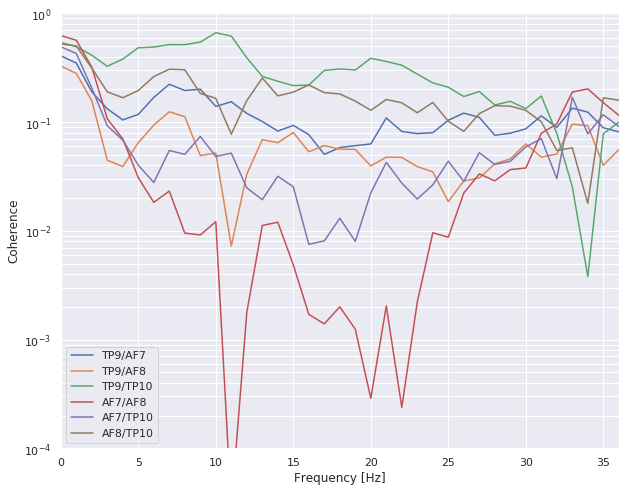

In [76]:
sns.set(rc={'figure.figsize':(10, 8)})

plot_coherence(1,2)
plot_coherence(1,3)
plot_coherence(1,4)
plot_coherence(2,3)
plot_coherence(2,4)
plot_coherence(3,4)

plt.legend()
plt.show()